In [1]:
import datetime
import numpy as np
import tensorflow as tf
print(tf.__version__)
import tensorflow_addons as tfa

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

2.1.0


In [2]:
%load_ext autoreload
%autoreload 2
from model import *
from contrast_loss_utils import *

In [3]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
# global configs
EPOCHS = 20
DATA = 'mnist-regression'
NORMALIZE_EMBEDDING = True
# NORMALIZE_EMBEDDING = False
N_DATA_TRAIN = 60000
# N_DATA_TRAIN = 10000
BATCH_SIZE = 32
PROJECTION_DIM = 128
WRITE_SUMMARY = False
ACTIVATION = 'leaky_relu'

In [5]:
!mkdir -p logs/

In [6]:
optimizer = tf.keras.optimizers.Adam()

# Load MNIST data

In [7]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


In [8]:
# simulate low data regime for training
n_train = x_train.shape[0]
shuffle_idx = np.arange(n_train)
np.random.shuffle(shuffle_idx)

x_train = x_train[shuffle_idx][:N_DATA_TRAIN]
y_train = y_train[shuffle_idx][:N_DATA_TRAIN]
print(x_train.shape, y_train.shape)

(60000, 784) (60000,)


In [9]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(5000).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

# Train baseline model

In [10]:
mlp = MLP(normalize=NORMALIZE_EMBEDDING, regress=True, activation=ACTIVATION)

In [11]:
mse_loss_obj = tf.keras.losses.MeanSquaredError()
# mse_loss_obj = tf.keras.losses.MeanSquaredLogarithmicError()

In [12]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_mae = tf.keras.metrics.MeanAbsoluteError(name='train_MAE')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_mae = tf.keras.metrics.MeanAbsoluteError(name='test_MAE')

In [13]:
@tf.function
def train_step_baseline(x, y):
    with tf.GradientTape() as tape:
        y_preds = mlp(x, training=True)
        loss = mse_loss_obj(y, y_preds)

    gradients = tape.gradient(loss, 
                              mlp.trainable_variables)
    optimizer.apply_gradients(zip(gradients, 
                                  mlp.trainable_variables))

    train_loss(loss)
    train_mae(y, y_preds)

In [14]:
@tf.function
def test_step_baseline(x, y):
    y_preds = mlp(x, training=False)
    t_loss = mse_loss_obj(y, y_preds)
    test_loss(t_loss)
    test_mae(y, y_preds)

In [15]:
model_name = 'baseline'
if WRITE_SUMMARY:
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/%s/%s/%s/train' % (model_name, DATA, current_time)
    test_log_dir = 'logs/%s/%s/%s/test' % (model_name, DATA, current_time)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [16]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_mae.reset_states()
    test_loss.reset_states()
    test_mae.reset_states()

    for x, y in train_ds:
        train_step_baseline(x, y)
        
    if WRITE_SUMMARY:
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('MAE', train_mae.result(), step=epoch)        

    for x_te, y_te in test_ds:
        test_step_baseline(x_te, y_te)

    if WRITE_SUMMARY:
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('MAE', test_mae.result(), step=epoch)        

    template = 'Epoch {}, Loss: {}, MAE: {}, Test Loss: {}, Test MAE: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_mae.result(),
                        test_loss.result(),
                        test_mae.result()))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 2.8237802982330322, MAE: 1.0710467100143433, Test Loss: 0.8426878452301025, Test MAE: 0.5530321002006531
Epoch 2, Loss: 0.6979140043258667, MAE: 0.4958041310310364, Test Loss: 0.7193371653556824, Test MAE: 0.48224782943725586
Epoch 3, Loss: 0.5503811836242676, MAE: 0.4342597424983978, Test Loss: 0.5642640590667725, Test MAE: 0.41329750418663025
Epoch 4, Loss: 0.46343323588371277, MAE: 0.39431002736091614, Test Loss: 0.4918504059314728, Test MAE: 0.3797064423561096
Epoch 5, Loss: 0.4104533

# Stage 1: train encoder with contrastive loss

In [49]:
encoder = Encoder(normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)

In [50]:
projector = Projector(PROJECTION_DIM, normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)

In [51]:
# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_mae = tf.keras.metrics.MeanAbsoluteError(name='train_contrast_MAE')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_mae = tf.keras.metrics.MeanAbsoluteError(name='test_contrast_MAE')

In [52]:
@tf.function
# train step for the contrast loss
def train_step_contrast(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:
        y_contrasts = get_contrast_batch_labels_regression(y)
        
        r = encoder(x, training=True)
        z = projector(r, training=True)
        
        D = pdist_euclidean(z)
        d_vec = square_to_vec(D)
        loss = tf.losses.mean_absolute_error(y_contrasts, d_vec)
#         loss = tf.losses.mean_squared_error(y_contrasts, d_vec)
#         loss = mse_loss_obj(y_contrasts, d_vec)

    gradients = tape.gradient(loss, 
                              encoder.trainable_variables + projector.trainable_variables)
    optimizer.apply_gradients(zip(gradients, 
                                  encoder.trainable_variables + projector.trainable_variables))

    train_loss(loss)
    train_mae(y_contrasts, d_vec)

In [53]:
@tf.function
def test_step_contrast(x, y):
    y_contrasts = get_contrast_batch_labels_regression(y)

    r = encoder(x, training=False)
    z = projector(r, training=False)

    D = pdist_euclidean(z)
    d_vec = square_to_vec(D)
    t_loss = tf.losses.mean_absolute_error(y_contrasts, d_vec)
#     t_loss = tf.losses.mean_squared_error(y_contrasts, d_vec)
#     t_loss = mse_loss_obj(y_contrasts, d_vec)

    test_loss(t_loss)
    test_mae(y_contrasts, d_vec)

In [54]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_mae.reset_states()
    test_loss.reset_states()
    test_mae.reset_states()

    for x, y in train_ds:
        train_step_contrast(x, y)

    for x_te, y_te in test_ds:
        test_step_contrast(x_te, y_te)

    template = 'Epoch {}, Loss: {}, MAE: {}, Test Loss: {}, Test MAE: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_mae.result(),
                        test_loss.result(),
                        test_mae.result()))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 2.083256959915161, MAE: 2.083256959915161, Test Loss: 2.0728654861450195, Test MAE: 2.0728654861450195
Epoch 2, Loss: 2.047395944595337, MAE: 2.047395944595337, Test Loss: 2.058706045150757, Test MAE: 2.058706045150757
Epoch 3, Loss: 2.0378928184509277, MAE: 2.0378928184509277, Test Loss: 2.0539588928222656, Test MAE: 2.0539588928222656
Epoch 4, Loss: 2.0341639518737793, MAE: 2.0341639518737793, Test Loss: 2.05523943901062, Test MAE: 2.05523943901062
Epoch 5, Loss: 2.0273807048797607, MAE

In [55]:
x_tr_proj = projector(encoder(x_train))
x_tr_proj.shape

TensorShape([60000, 256])

In [56]:
x_te_proj = projector(encoder(x_test))
x_te_proj.shape

TensorShape([10000, 256])

In [57]:
# convert tensor to np.array
x_tr_proj = x_tr_proj.numpy()
x_te_proj = x_te_proj.numpy()
print(x_tr_proj.shape, x_te_proj.shape)

(60000, 256) (10000, 256)


In [58]:
x_test.shape

(10000, 784)

## Check learned embedding

In [59]:
from sklearn.decomposition import PCA

In [60]:
# do PCA for the projected data
pca = PCA(n_components=2)
pca.fit(x_tr_proj)
x_te_proj_pca = pca.transform(x_te_proj)
x_te_proj_pca.shape

(10000, 2)

In [61]:
# do PCA for original data
pca = PCA(n_components=2)
pca.fit(x_train)
x_te_pca = pca.transform(x_test)
x_te_pca.shape

(10000, 2)

In [62]:
x_te_proj_df = pd.DataFrame(x_te_proj[:, :2], columns=['Proj1', 'Proj2'])
x_te_proj_df['label'] = y_test
# x_te_proj_df.head()

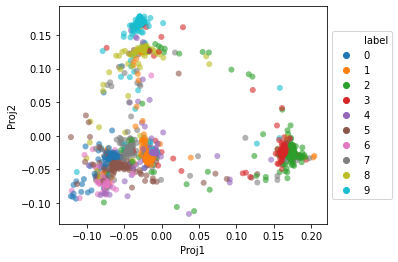

In [63]:
ax = sns.scatterplot('Proj1', 'Proj2', data=x_te_proj_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

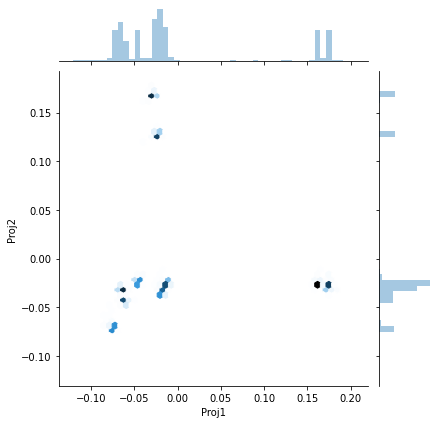

In [64]:
sns.jointplot('Proj1', 'Proj2', data=x_te_proj_df,
              kind="hex"
             );

In [65]:
x_te_proj_pca_df = pd.DataFrame(x_te_proj_pca, columns=['PC1', 'PC2'])
x_te_proj_pca_df['label'] = y_test

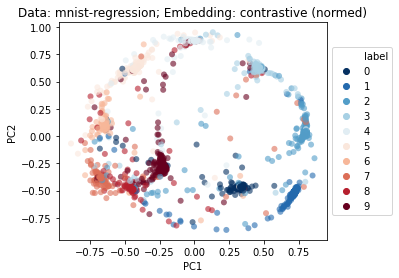

In [78]:
ax = sns.scatterplot('PC1', 'PC2', data=x_te_proj_pca_df,
#                 palette='tab10',
                     palette='RdBu_r',
                     legend='full',
                hue='label',
                linewidth=0,
                alpha=0.6
               );

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
title = 'Data: %s; Embedding: contrastive'% DATA
if NORMALIZE_EMBEDDING:
    title = 'Data: %s; Embedding: contrastive (normed)'% DATA
ax.set_title(title);

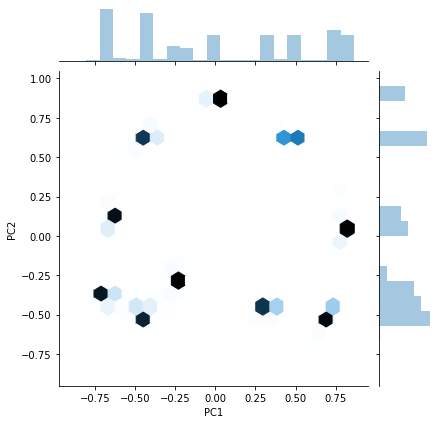

In [67]:
sns.jointplot('PC1', 'PC2', data=x_te_proj_pca_df,
              kind="hex"
             )

In [68]:
x_te_pca_df = pd.DataFrame(x_te_pca, columns=['PC1', 'PC2'])
x_te_pca_df['label'] = y_test

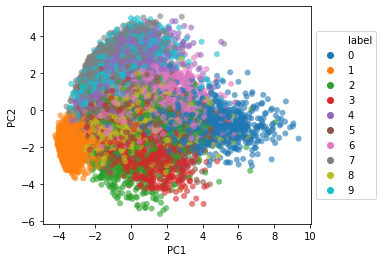

In [40]:
ax = sns.scatterplot('PC1', 'PC2', data=x_te_pca_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

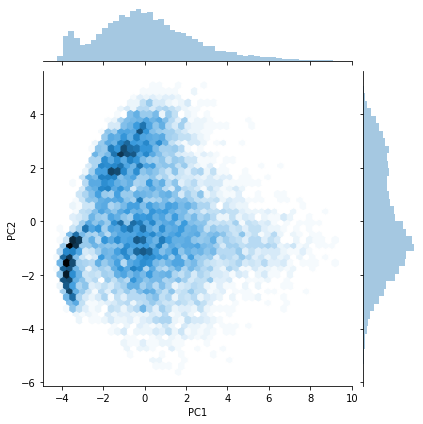

In [41]:
sns.jointplot('PC1', 'PC2', data=x_te_pca_df,
              kind="hex"
             );

# Stage 2: freeze the learned representations and then learn a classifier on a linear layer using a softmax loss

In [69]:
dense1 = tf.keras.layers.Dense(1)

In [70]:
# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_mae = tf.keras.metrics.MeanAbsoluteError(name='train_MAE')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_mae = tf.keras.metrics.MeanAbsoluteError(name='test_MAE')

In [71]:
mse_loss_obj = tf.keras.losses.MeanSquaredError()
# mse_loss_obj = tf.keras.losses.MeanSquaredLogarithmicError()

In [72]:
@tf.function
# train step for the 2nd stage
def train_step(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        r = encoder(x, training=False)
        y_preds = dense1(r, training=True)
        loss = mse_loss_obj(y, y_preds)

    # freeze the encoder, only train the softmax layer
    gradients = tape.gradient(loss, 
                              dense1.trainable_variables) 
    optimizer.apply_gradients(zip(gradients, 
                                  dense1.trainable_variables))

    train_loss(loss)
    train_mae(y, y_preds)

In [73]:
@tf.function
def test_step(x, y):
    r = encoder(x, training=False)
    y_preds = dense1(r, training=False)

    t_loss = mse_loss_obj(y, y_preds)

    test_loss(t_loss)
    test_mae(y, y_preds)

In [74]:
model_name = 'contrast_loss_model'
if WRITE_SUMMARY:
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/%s/%s/%s/train' % (model_name, DATA, current_time)
    test_log_dir = 'logs/%s/%s/%s/test' % (model_name, DATA, current_time)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [75]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_mae.reset_states()
    test_loss.reset_states()
    test_mae.reset_states()

    for x, y in train_ds:
        train_step(x, y)

    if WRITE_SUMMARY:
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_mae.result(), step=epoch)        
        
    for x_te, y_te in test_ds:
        test_step(x_te, y_te)

    if WRITE_SUMMARY:
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_mae.result(), step=epoch)        
        
    template = 'Epoch {}, Loss: {}, MAE: {}, Test Loss: {}, Test MAE: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_mae.result(),
                        test_loss.result(),
                        test_mae.result()))

Epoch 1, Loss: 3.795982599258423, MAE: 1.4382041692733765, Test Loss: 0.9934551119804382, Test MAE: 0.7178249955177307
Epoch 2, Loss: 0.785662055015564, MAE: 0.6335952877998352, Test Loss: 0.8083279728889465, Test MAE: 0.6075527667999268
Epoch 3, Loss: 0.669380784034729, MAE: 0.5675774812698364, Test Loss: 0.7388636469841003, Test MAE: 0.5636270046234131
Epoch 4, Loss: 0.6098958849906921, MAE: 0.5326380729675293, Test Loss: 0.7011398077011108, Test MAE: 0.5370151400566101
Epoch 5, Loss: 0.5745635032653809, MAE: 0.5107950568199158, Test Loss: 0.6754878759384155, Test MAE: 0.5223477482795715
Epoch 6, Loss: 0.5513440370559692, MAE: 0.49681177735328674, Test Loss: 0.6592786312103271, Test MAE: 0.5099886059761047
Epoch 7, Loss: 0.5344374179840088, MAE: 0.4863491654396057, Test Loss: 0.6451706886291504, Test MAE: 0.5032541155815125
Epoch 8, Loss: 0.5212585926055908, MAE: 0.47850459814071655, Test Loss: 0.6350823044776917, Test MAE: 0.49657273292541504
Epoch 9, Loss: 0.5102776885032654, MAE: 

In [46]:
test_mae.result().numpy()

0.8931